<a href="https://colab.research.google.com/github/Zaxis018/efficientnet_object_detection/blob/main/object_detector_from_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install imutils

In [10]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.transforms.functional as F
import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt
import time
import argparse

In [12]:
model = torch.load('efficientnetv2.pth')
model.eval()


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): Hardswish()
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2):

In [43]:
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", default = "./bird_airplane.jpg", #required=False,
    help="path to the input image")
ap.add_argument("-s", "--size", type=str, default="(200, 150)",
    help="ROI size (in pixels)")
ap.add_argument("-c", "--min-conf", type=float, default=0.7,
    help="minimum probability to filter weak detections")
ap.add_argument("-v", "--visualize", type=int, default=1,
    help="whether or not to show extra visualizations for debugging")
args = vars(ap.parse_args([]))

In [44]:
def cv2_to_tensor(image):
    image = F.to_tensor(image)
    image = F.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    return image.unsqueeze(0)
image = cv2.imread(args["image"])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

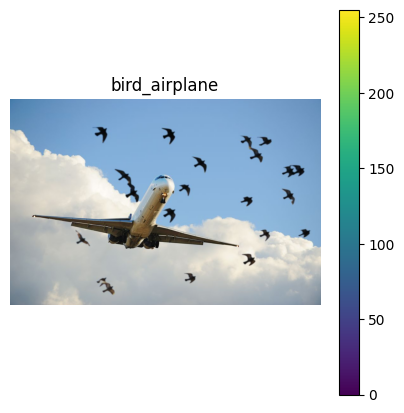

In [45]:
# Display image
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.set_title("bird_airplane")
plt.imshow(image)
plt.axis("off")
plt.colorbar()

In [46]:
WIDTH = 600 #
PYR_SCALE = 1.5
WIN_STEP = 16*3 # running on laptop so I generated a small pyramid
ROI_SIZE = eval(args["size"])
INPUT_SIZE = (224, 224) #input size for efficientnet_model

In [47]:
def image_pyramid(image, scale=1.5, minSize=(224, 224)):
    # yield the original image, this is the base of the image pyramid
    yield image
    # keep looping over the image pyramid
    while True:
        # compute the dimensions of the next image in the pyramid
        #scale controls how much the image is resized at each layer
        w = int(image.shape[1] / scale)
        # resize the image and take care of image aspect-ratio
        image = imutils.resize(image, width=w)
        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        # yield the next image in the pyramid
        yield image

In [48]:
orig = image
orig = imutils.resize(orig, width=WIDTH)
(H, W) = orig.shape[:2]

pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)
rois = []
locs = []
start = time.time()
tot_images = 0


In [49]:
def sliding_window_pytorch(image, step, ws):
    for y in range(0, image.shape[0] - ws[1], step):
        for x in range(0, image.shape[1] - ws[0], step):
            yield (x, y, image[y:y + ws[1], x:x + ws[0]])


In [50]:
for p, image in enumerate(pyramid):
    scale = W / float(image.shape[1])
    sw = 0
    for (x, y, roiOrig) in sliding_window_pytorch(image, WIN_STEP, ROI_SIZE):
        sw += 1
        x = int(x * scale)
        y = int(y * scale)
        w = int(ROI_SIZE[0] * scale)
        h = int(ROI_SIZE[1] * scale)

        roi = cv2.resize(roiOrig, INPUT_SIZE)
        roi = cv2_to_tensor(roi)

        rois.append(roi)
        locs.append((x, y, x + w, y + h))

        if args["visualize"] > 0:
            clone = orig.copy()
            cv2.rectangle(clone, (x, y), (x + w, y + h), (0, 255, 0), 5)
            tot_images += 1

In [51]:
end = time.time()
print("[INFO] looping over pyramid/windows took {:.5f} seconds".format(end - start))
print("Total images {:.2f}".format(tot_images))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

rois = torch.cat(rois, dim=0)
with torch.no_grad():
    rois = rois.to(device)  # Assuming  GPU
    my_preds = model(rois)

[INFO] looping over pyramid/windows took 0.09597 seconds
Total images 71.00


In [52]:
# Move the tensor to CPU, then convert to NumPy array
rois = rois.cpu().numpy()

rois = np.array(rois, dtype="float32")
# classify each of the proposal ROIs using ResNet and then show how
# long the classifications took
print("[INFO] classifying ROIs...")
start = time.time()
# Assuming `model` is your PyTorch model and `rois` is your input data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Temporarily turn off gradient descent
    rois = torch.from_numpy(rois)  # Convert the NumPy array to a PyTorch tensor
    rois = rois.to(device)  # Move the tensor to the device where the model is
    my_preds = model(rois)  # Make predictions

end = time.time()
print("[INFO] classifying ROIs took {:.5f} seconds".format(end - start))

[INFO] classifying ROIs...
[INFO] classifying ROIs took 0.03794 seconds


In [53]:
import torch.nn.functional as Fu

In [54]:
#  `my_preds` is the output of  model,apply softmax to it
my_preds = Fu.softmax(my_preds, dim=1)
predicted_probs, predicted_indices = torch.max(my_preds, 1)

# Load the class labels used by the pre-trained model
with open('cifar_10_classes.txt') as f:
    class_labels = [line.strip() for line in f.readlines()]

# Map the predicted indices and probabilities to the class labels
predicted_classes = [[(str(i.item()), class_labels[i], prob.item())] for i, prob in zip(predicted_indices, predicted_probs)]

# Now `predicted_classes` is a list of lists, where each inner list contains a single tuple with the class ID, class label, and prediction probability


In [55]:
predicted_classes

[[('0', 'airplane', 0.9629828333854675)],
 [('2', 'bird', 0.5536795258522034)],
 [('2', 'bird', 0.8997412323951721)],
 [('2', 'bird', 0.9792560338973999)],
 [('2', 'bird', 0.8681262135505676)],
 [('2', 'bird', 0.9877685904502869)],
 [('2', 'bird', 0.8819306492805481)],
 [('2', 'bird', 0.8900772929191589)],
 [('2', 'bird', 0.9587876796722412)],
 [('0', 'airplane', 0.6964285373687744)],
 [('0', 'airplane', 0.9729510545730591)],
 [('2', 'bird', 0.7203176617622375)],
 [('2', 'bird', 0.845854640007019)],
 [('0', 'airplane', 0.6093153357505798)],
 [('2', 'bird', 0.8945642709732056)],
 [('2', 'bird', 0.7414571046829224)],
 [('2', 'bird', 0.826799213886261)],
 [('2', 'bird', 0.8733490109443665)],
 [('6', 'frog', 0.47186923027038574)],
 [('0', 'airplane', 0.34453487396240234)],
 [('0', 'airplane', 0.8244007229804993)],
 [('0', 'airplane', 0.6833429336547852)],
 [('2', 'bird', 0.5515723824501038)],
 [('2', 'bird', 0.6818487048149109)],
 [('2', 'bird', 0.7809321880340576)],
 [('2', 'bird', 0.7776

In [56]:
# labels (keys) to any ROIs associated with that label (values)
#preds = tf.keras.applications.imagenet_utils.decode_predictions(my_preds, top=1)
labels = {}
#probs = {}
# loop over the predictions
for (i, p) in enumerate(predicted_classes):
    # grab the prediction information for the current ROI
    (imagenetID, label, prob) = p[0]

    # filter out weak detections by ensuring the predicted probability
    # is greater than the minimum probability
    if prob >= 0.9: #args["min_conf"]:
        # grab the bounding box associated with the prediction and
        # convert the coordinates
        box = locs[i]

        # grab the list of predictions for the label and add the
        # bounding box and probability to the list
        L = labels.get(label, [])
        L.append((box, prob))
        labels[label] = L

In [57]:
def non_max_suppressions(boxes, probs, overlapThresh):
    # If there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # Initialize the list of picked indexes
    pick = []

    # Compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (boxes[:, 2] - boxes[:, 0] + 1) * (boxes[:, 3] - boxes[:, 1] + 1)
    idxs = np.argsort(probs)

    # Keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # Grab the last index in the indexes list and add the index value
        # to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # Find the largest (x, y) coordinates for the start of the bounding box
        # and the smallest (x, y) coordinates for the end of the bounding box
        xx1 = np.maximum(boxes[i, 0], boxes[idxs[:last], 0])
        yy1 = np.maximum(boxes[i, 1], boxes[idxs[:last], 1])
        xx2 = np.minimum(boxes[i, 2], boxes[idxs[:last], 2])
        yy2 = np.minimum(boxes[i, 3], boxes[idxs[:last], 3])

        # Compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # Compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # Delete all indexes from the index list that have overlap greater
        # than the provided overlap threshold
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    # Return only the bounding boxes that were picked
    return boxes[pick].astype("int")


[INFO] showing results for 'airplane'
[[108   0 559 338]] [0.96298283 0.97295105 0.91480207 0.9988901  0.99991667 0.99975699
 0.98317772 0.98104596 0.99942952 0.99948126 0.99727124 0.99083239
 0.97100484 0.92009395 0.99324    0.99351269 0.96223879 0.9467628
 0.92664063 0.97696358 0.99418986 0.98048168 0.94602799 0.96574491
 0.95392191 0.99266267 0.98487979 0.99232751 0.99847335 0.99922609
 0.99963522 0.99977714 0.9998858  0.99884474 0.99927408 0.99993265]
[INFO] showing results for 'bird'
[[240   0 440 150]
 [384 144 584 294]] [0.97925603 0.98776859 0.95878768 0.90609592 0.9374041 ]


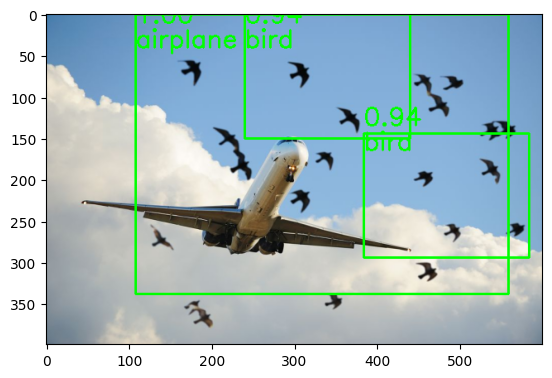

In [58]:
allclone = orig.copy()
for label in labels.keys():
    # clone the original image so that we can draw on it
    print("[INFO] showing results for '{}'".format(label))
    clone = orig.copy()

    # loop over all bounding boxes for the current label
    for (box, prob) in labels[label]:
        # draw the bounding box on the image
        (startX, startY, endX, endY) = box
        cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)

    # show the results *before* applying non-maxima suppression, then
    # clone the image again so we can display the results *after*
    # applying non-maxima suppression
    #plt.imshow(clone)
    #cv2.imshow("Before", clone)
    clone = orig.copy()

    # extract the bounding boxes and associated prediction
    # probabilities, then apply non-maxima suppression
    boxes = np.array([p[0] for p in labels[label]])
    proba = np.array([p[1] for p in labels[label]])
    boxes = non_max_suppressions(boxes, proba,0.1)
    print(boxes,proba)

    # loop over all bounding boxes that were kept after applying
    # non-maxima suppression
    for (startX, startY, endX, endY) in boxes:
        # draw the bounding box and label on the image
        cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)
        cv2.rectangle(allclone, (startX, startY), (endX, endY),(0, 255, 0), 2)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.putText(clone, label, (startX, y+30),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(clone, "{:.2f}".format(prob), (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(allclone, label, (startX, y+30),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(allclone, "{:.2f}".format(prob), (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    # show the output after apply non-maxima suppression
    plt.imshow(clone)
    plt.imsave("./detetcted" + label + ".jpg", clone)
plt.imshow(allclone)
plt.imsave("./detected.jpg", allclone)
    #plt.imshow(clone)
    #plt.imsave("images/_res03.jpg", clone)
    #cv2.imshow("After", clone)
    #cv2.waitKey(0)
